In [1]:
import os

import torch
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

from neulight.dataset.free_viewpoint import FreeViewpointDataset
from neulight.model.neus import NeuSLightningModel
from neulight.utils.files import read_file
from neulight.visualization.visualize_rays import visualize_rays

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Read Config

In [2]:
config = read_file("../config/neus.yaml")

## Sample a batch of rays from the training dataset

In [3]:
dtype = torch.float32
device = torch.cuda.current_device()
batch_size = 4
num_workers = 2
free_viewpoint_scene_path = "../data/neulight/Salon2"
num_rays_per_image = 1024

In [4]:
free_viewpoint_train_dataset = FreeViewpointDataset(
    scene_path=free_viewpoint_scene_path,
    dataset_type="train",
    num_rays_per_image=num_rays_per_image,
)
free_viewpoint_train_dataloader = DataLoader(
    free_viewpoint_train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=free_viewpoint_train_dataset.collate_fn,
    num_workers=num_workers,
    persistent_workers=True,
)

In [5]:
batch = free_viewpoint_train_dataset.move_batch_to(
    next(iter(free_viewpoint_train_dataloader)),
    device=device,
    dtype=dtype,
)

In [6]:
image = visualize_rays(
    batch["inputs"]["rays"],
    batch["labels"]["colors"],
    interactive=False,
)

FEngine (64 bits) created at 0x55996d8eb6a0 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


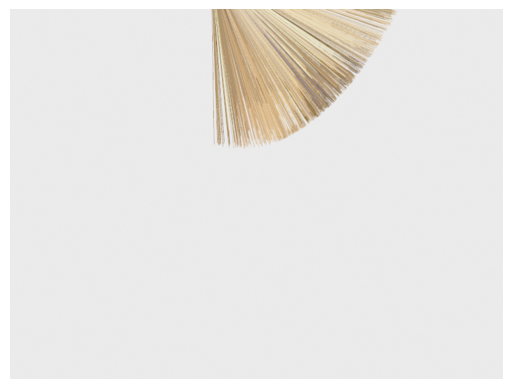

In [7]:
plt.imshow(image)
plt.axis("off")
plt.show()

In [8]:
batch["inputs"]["rays"][:, 0, :]

tensor([[-20.2825,  -5.1112,  11.9145,   0.7580,   0.5341,  -0.3744],
        [ -8.3271,  -9.7261,   9.5770,   0.6454,   0.4069,  -0.6464],
        [-11.7361,  -2.4026,  10.2469,   0.2316,   0.9408,  -0.2473],
        [  2.2392,   9.6373,   4.0351,  -0.3472,  -0.9375,  -0.0248]],
       device='cuda:0')

## Initialize the model

In [9]:
neus_model = NeuSLightningModel(config["model"]).to(device)

In [10]:
batch["predicts"] = neus_model(batch["inputs"])

In [11]:
from neulight.utils.torch_numpy import detect_nan

In [12]:
detect_nan(batch["predicts"]["colors"], "colors")

In [13]:
loss = neus_model.loss(batch["predicts"]["colors"], batch["labels"]["colors"])

/home/mukaiy/miniforge3/envs/neulight/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [14]:
loss

tensor(2.1162, device='cuda:0', grad_fn=<AddBackward0>)

In [15]:
loss.backward()

In [16]:
batch["predicts"]["colors"]

tensor([[[0.4992, 0.5153, 0.7491],
         [0.4727, 0.5255, 0.7013],
         [0.5183, 0.4953, 0.7039],
         ...,
         [0.4812, 0.4742, 0.7143],
         [0.5082, 0.5075, 0.6925],
         [0.5377, 0.5063, 0.7149]],

        [[0.5089, 0.5325, 0.6971],
         [0.4915, 0.4940, 0.7385],
         [0.4557, 0.5357, 0.6602],
         ...,
         [0.4930, 0.5821, 0.6898],
         [0.4824, 0.5034, 0.7060],
         [0.4946, 0.5453, 0.7162]],

        [[0.4815, 0.5174, 0.6535],
         [0.4984, 0.5258, 0.6586],
         [0.4932, 0.5155, 0.6870],
         ...,
         [0.4916, 0.4470, 0.6095],
         [0.4391, 0.4816, 0.6954],
         [0.5086, 0.4890, 0.6742]],

        [[0.4718, 0.5088, 0.6686],
         [0.4511, 0.5361, 0.7373],
         [0.4558, 0.4483, 0.7214],
         ...,
         [0.5053, 0.5058, 0.7049],
         [0.5104, 0.4744, 0.7398],
         [0.4834, 0.5428, 0.6778]]], device='cuda:0', grad_fn=<SumBackward1>)